In [1]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
from ydata_profiling import ProfileReport
import numpy as np
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import seaborn as sns
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample

In [2]:
#ponte de conexão com o redshift
connection = psycopg2.connect(dbname="dw_amorsaude",
                  user="",
                  password="",
                  host ="redshift.amazonaws.com",
                  port = 5439)

In [3]:
#query
df_tm = '''with base0 as ( 
select 
row_number () OVER(ORDER by lm.paciente_id, cast(lm.data_hora as time) ) as indice0,
lm.paciente_id as paciente, cast(lm.data_hora as time) as hora0, to_char(lm."data", 'Month') as mes, lm.procedimento_id as id_procedimento,
tcah.nome_especialidade, 
lm.status_id as status_id , sas.nome_status as nome_status,  sur.descricao as regional, u.id as id_unidade, u.nome_fantasia, lm."data" as data,
case 
	when lm.status_id = 204 then 2 --retirado status id = 1 (agendado) para efeito de limpeza
	when lm.status_id = 202 then 3
	when lm.status_id = 33 then 4
	when lm.status_id = 5 then 5
	when lm.status_id = 2 then 6
	when lm.status_id = 3 then 7
	when lm.status_id = 201 then 8
	when lm.status_id = 205 then 10
	when lm.status_id = 203 then 11
	else 0
	end as fila_status,
case when fila_status in (1,2,3,5,4) then 'Pré atendimento'
	when fila_status in (6,7) then 'Atendimento'
	when fila_status in (8,10,11) then 'Pós consulta'
	else '0'
	end as agrupamento_status
from stg_log_marcacoes lm
left join stg_unidades u on u.id = lm.unidade_id
left join stg_unidades_regioes sur on sur.id = u.regiao_id
left join stg_agendamento_status sas on sas.id = lm.status_id
left join tb_consolidacao_agendamentos_hist tcah on tcah.id_agendamento = lm.agendamento_id 
--and u.nome_fantasia = 'AmorSaúde Serrinha'
where 1=1
and lm.unidade_id is not null
and sur.descricao is not null
and sas.nome_status is not null
and lm.status_id  in (2, 3, 33, 202, 204, 5, 201, 205, 203)
and lm."data" between '2020-01-01' and current_date
and lm.paciente_id not in (-1)
--and lm.paciente_id = 65862680
and u.id not in (19865)
order by lm.paciente_id, fila_status, lm."data"),
final_objeto as (
select indice0, data, paciente, hora0, mes, status_id , nome_status, 
regional, fila_status, agrupamento_status, id_unidade, nome_fantasia, id_procedimento,nome_especialidade,
lag(hora0,1) over (order by paciente) as lag0, lag0 - hora0 as duracao
from base0
where 1=1
and id_unidade in (19932, 19935, 19728, 19462, 19830, 19855, 19957) -- filtrando as unidades do Ícaro
)
select indice0, data, paciente, hora0, lag0, mes, status_id , nome_status, 
regional, fila_status, agrupamento_status, id_unidade, nome_fantasia, id_procedimento, nome_especialidade,
duracao
from final_objeto'''

In [4]:
#df = pd.read_sql_query(df_emails,con=connection)
df_tm = pd.read_sql_query(df_tm,con=connection)

/tmp/ipykernel_40877/1537762496.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tm = pd.read_sql_query(df_tm,con=connection)


In [5]:
df_tm1 = df_tm

In [6]:
# Converta as colunas lag0 e hora0 para o formato de minutos e segundos
df_tm1['lag0_minutos'] = df_tm1['lag0'].apply(lambda x: x.minute + x.second / 60 if x is not None else None)
df_tm1['hora0_minutos'] = df_tm1['hora0'].apply(lambda x: x.minute + x.second / 60 if x is not None else None)

# Calcula a diferença entre as colunas lag0 e hora0 em minutos e segundos
df_tm1['duracao_d_minutos'] = (df_tm1['lag0_minutos'] - df_tm1['hora0_minutos'])

df_tm1.dropna(inplace=True)

In [7]:
df_tm1

,indice0,data,paciente,hora0,lag0,mes,status_id,nome_status,regional,fila_status,agrupamento_status,id_unidade,nome_fantasia,id_procedimento,nome_especialidade,duracao,lag0_minutos,hora0_minutos,duracao_d_minutos
0,85896245,2023-08-30,66887439,16:09:53,17:09:34,August,5,Chamando,MG,5,Pré atendimento,19935,AmorSaúde Araguari,5024,Clinica Médica,0 days 00:59:41,9.566667,9.883333,-0.316667
1,85896246,2023-08-30,66887439,17:09:34,17:17:42,August,2,Em atendimento,MG,6,Atendimento,19935,AmorSaúde Araguari,5024,Clinica Médica,0 days 00:08:08,17.700000,9.566667,8.133333
2,85896247,2023-08-30,66887439,17:17:42,14:20:17,August,3,Atendido,MG,7,Atendimento,19935,AmorSaúde Araguari,5024,Clinica Médica,-1 days +21:02:35,20.283333,17.700000,2.583333
3,85895839,2023-08-30,66884094,14:20:17,15:06:43,August,5,Chamando,MG,5,Pré atendimento,19728,AmorSaúde Uberlândia,5003,Oftalmologia,0 days 00:46:26,6.716667,20.283333,-13.566667
4,85895840,2023-08-30,66884094,15:06:43,15:10:58,August,2,Em atendimento,MG,6,Atendimento,19728,AmorSaúde Uberlândia,5003,Oftalmologia,0 days 00:04:15,10.966667,6.716667,4.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756707,3243,2023-08-07,1178,13:36:21,14:01:51,August,3,Atendido,SP CAV,7,Atendimento,19932,AmorSaúde Ribeirão Pires,5010,Neurologia,0 days 00:25:30,1.850000,36.350000,-34.500000
756708,449,2023-06-09,103,14:01:51,14:09:56,June,2,Em atendimento,SP CAV,6,Atendimento,19932,AmorSaúde Ribeirão Pires,5000,Ginecologia,0 days 00:08:05,9.933333,1.850000,8.083333
756709,451,2023-06-09,103,14:09:56,13:09:12,June,3,Atendido,SP CAV,7,Atendimento,19932,AmorSaúde Ribeirão Pires,5000,Ginecologia,-1 days +22:59:16,9.200000,9.933333,-0.733333
756710,94,2022-12-08,45,13:09:12,13:22:34,December,5,Chamando,SP Interior,5,Pré atendimento,19957,AmorSaúde Batatais,5002,Medicina de Família e Comunidade,0 days 00:13:22,22.566667,9.200000,13.366667


In [8]:
# Selecione apenas as linhas onde a coluna 'duracao_d_minutos' não é negativa
df_tm1 = df_tm1.loc[df_tm1['duracao_d_minutos'] >= 0]

In [9]:
df_tm1

,indice0,data,paciente,hora0,lag0,mes,status_id,nome_status,regional,fila_status,agrupamento_status,id_unidade,nome_fantasia,id_procedimento,nome_especialidade,duracao,lag0_minutos,hora0_minutos,duracao_d_minutos
1,85896246,2023-08-30,66887439,17:09:34,17:17:42,August,2,Em atendimento,MG,6,Atendimento,19935,AmorSaúde Araguari,5024,Clinica Médica,0 days 00:08:08,17.700000,9.566667,8.133333
2,85896247,2023-08-30,66887439,17:17:42,14:20:17,August,3,Atendido,MG,7,Atendimento,19935,AmorSaúde Araguari,5024,Clinica Médica,-1 days +21:02:35,20.283333,17.700000,2.583333
4,85895840,2023-08-30,66884094,15:06:43,15:10:58,August,2,Em atendimento,MG,6,Atendimento,19728,AmorSaúde Uberlândia,5003,Oftalmologia,0 days 00:04:15,10.966667,6.716667,4.250000
5,85895841,2023-08-30,66884094,15:10:58,15:29:58,August,3,Atendido,MG,7,Atendimento,19728,AmorSaúde Uberlândia,5003,Oftalmologia,0 days 00:19:00,29.966667,10.966667,19.000000
9,85895441,2023-08-30,66881436,12:49:56,12:53:39,August,2,Em atendimento,RJ,6,Atendimento,19462,AmorSaúde Macaé,5000,Ginecologia,0 days 00:03:43,53.650000,49.933333,3.716667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756704,9978,2021-01-13,3447,21:32:26,21:56:02,January,2,Em atendimento,MG,6,Atendimento,19728,AmorSaúde Uberlândia,5000,Ginecologia,0 days 00:23:36,56.033333,32.433333,23.600000
756706,3242,2023-08-07,1178,13:33:27,13:36:21,August,2,Em atendimento,SP CAV,6,Atendimento,19932,AmorSaúde Ribeirão Pires,5010,Neurologia,0 days 00:02:54,36.350000,33.450000,2.900000
756708,449,2023-06-09,103,14:01:51,14:09:56,June,2,Em atendimento,SP CAV,6,Atendimento,19932,AmorSaúde Ribeirão Pires,5000,Ginecologia,0 days 00:08:05,9.933333,1.850000,8.083333
756710,94,2022-12-08,45,13:09:12,13:22:34,December,5,Chamando,SP Interior,5,Pré atendimento,19957,AmorSaúde Batatais,5002,Medicina de Família e Comunidade,0 days 00:13:22,22.566667,9.200000,13.366667


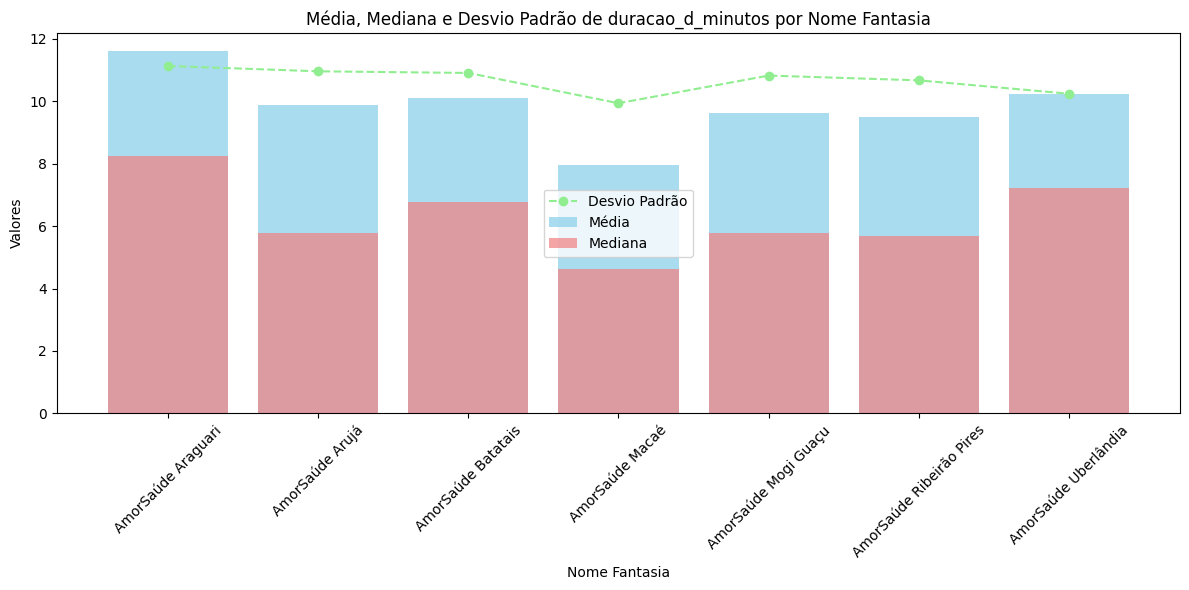

In [11]:

agregacoes = {
    'Média': ('duracao_d_minutos', 'mean'),
    'Mediana': ('duracao_d_minutos', 'median'),
    'Desvio Padrão': ('duracao_d_minutos', 'std')
}

resultado = df_tm1.groupby('nome_fantasia').agg(**agregacoes).reset_index()

# Criar um gráfico de barras
plt.figure(figsize=(12, 6))
cores = ['skyblue', 'lightcoral']  # Cores para as barras
linhas_cores = 'lightgreen'  # Cor da linha de desvio padrão

# Gráfico de barras
for i, coluna in enumerate(['Média', 'Mediana']):
    plt.bar(
        resultado['nome_fantasia'],
        resultado[coluna],
        label=coluna,
        color=cores[i],
        alpha=0.7,
    )

# Linha de desvio padrão
plt.plot(
    resultado['nome_fantasia'],
    resultado['Desvio Padrão'],
    marker='o',
    linestyle='--',
    color=linhas_cores,
    label='Desvio Padrão',
)

plt.xlabel('Nome Fantasia')
plt.ylabel('Valores')
plt.title('Média, Mediana e Desvio Padrão de duracao_d_minutos por Nome Fantasia')
plt.xticks(rotation=45)

# Adicionar legendas
plt.legend()

plt.tight_layout()
plt.show()


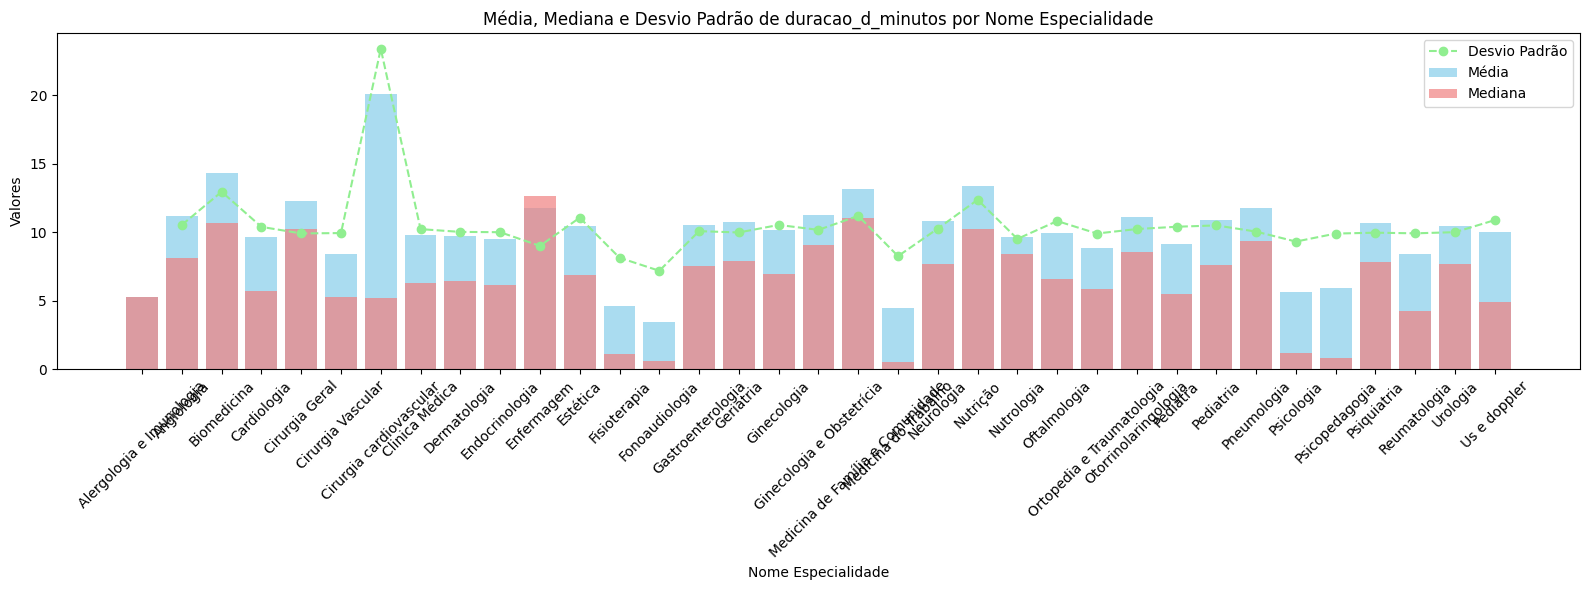

In [12]:

agregacoes = {
    'Média': ('duracao_d_minutos', 'mean'),
    'Mediana': ('duracao_d_minutos', 'median'),
    'Desvio Padrão': ('duracao_d_minutos', 'std')
}

resultado = df_tm1.groupby('nome_especialidade').agg(**agregacoes).reset_index()

# Criar um gráfico de barras
plt.figure(figsize=(16, 6))
cores = ['skyblue', 'lightcoral']  # Cores para as barras
linhas_cores = 'lightgreen'  # Cor da linha de desvio padrão

# Gráfico de barras
for i, coluna in enumerate(['Média', 'Mediana']):
    plt.bar(
        resultado['nome_especialidade'],
        resultado[coluna],
        label=coluna,
        color=cores[i],
        alpha=0.7,
    )

# Linha de desvio padrão
plt.plot(
    resultado['nome_especialidade'],
    resultado['Desvio Padrão'],
    marker='o',
    linestyle='--',
    color=linhas_cores,
    label='Desvio Padrão',
)

plt.xlabel('Nome Especialidade')
plt.ylabel('Valores')
plt.title('Média, Mediana e Desvio Padrão de duracao_d_minutos por Nome Especialidade')
plt.xticks(rotation=45)

# Adicionar legendas
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
df_tm2 = df_tm1

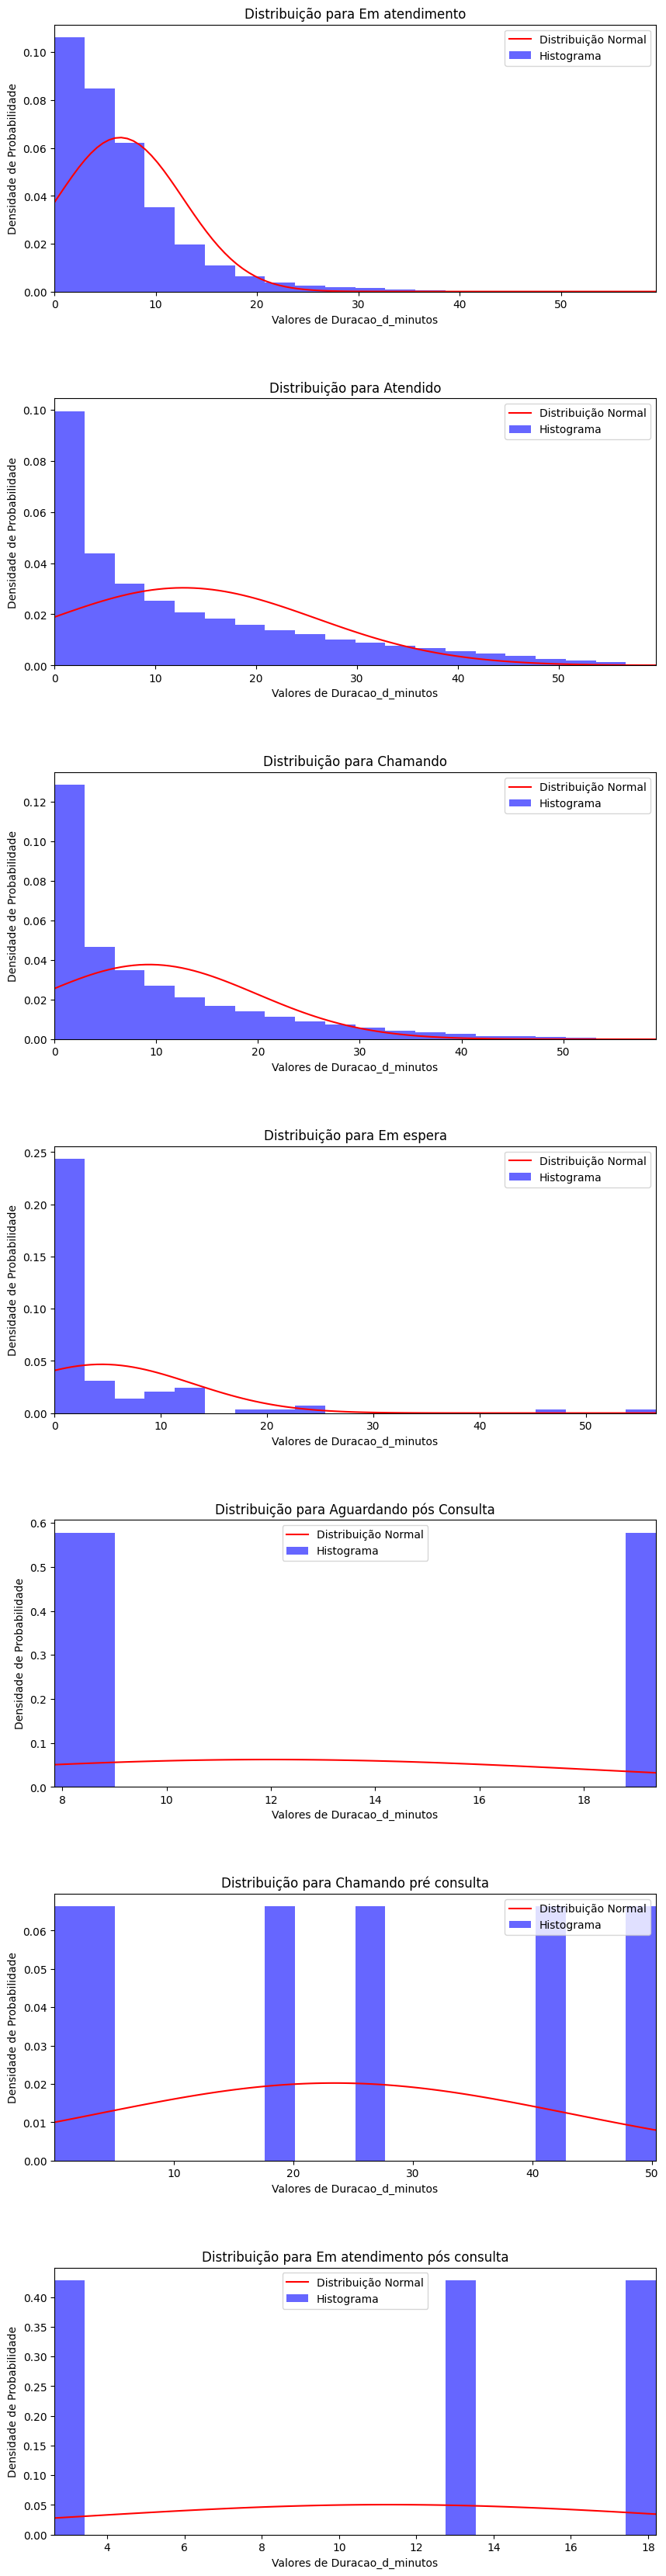

In [14]:
from scipy.stats import norm

# Lista de todos os valores únicos em 'nome_status'
nomes_de_status = df_tm1['nome_status'].unique()

# Configurar subplots para criar um gráfico para cada nome_status
num_plots = len(nomes_de_status)
fig, axes = plt.subplots(num_plots, figsize=(10, 6*num_plots))
plt.subplots_adjust(hspace=0.4)

# Loop através de cada nome_status e criar a distribuição normal
for i, status in enumerate(nomes_de_status):
    dados = df_tm1[df_tm1['nome_status'] == status]['duracao_d_minutos']
    media = dados.mean()
    desvio_padrao = dados.std()
    
    x = np.linspace(dados.min(), dados.max(), 100)
    y = norm.pdf(x, media, desvio_padrao)
    
    # Plotar a distribuição normal
    axes[i].plot(x, y, label='Distribuição Normal', color='red')
    
    # Plotar um histograma dos dados
    axes[i].hist(dados, bins=20, density=True, alpha=0.6, color='blue', label='Histograma')
    
    # Configurar os limites do eixo x para limitar o intervalo
    limites_x = [dados.min(), dados.max()]
    axes[i].set_xlim(limites_x)
    
    # Configurar títulos e legendas
    axes[i].set_title(f'Distribuição para {status}')
    axes[i].set_xlabel('Valores de Duracao_d_minutos')
    axes[i].set_ylabel('Densidade de Probabilidade')
    axes[i].legend()

# Exibir os gráficos
plt.show()

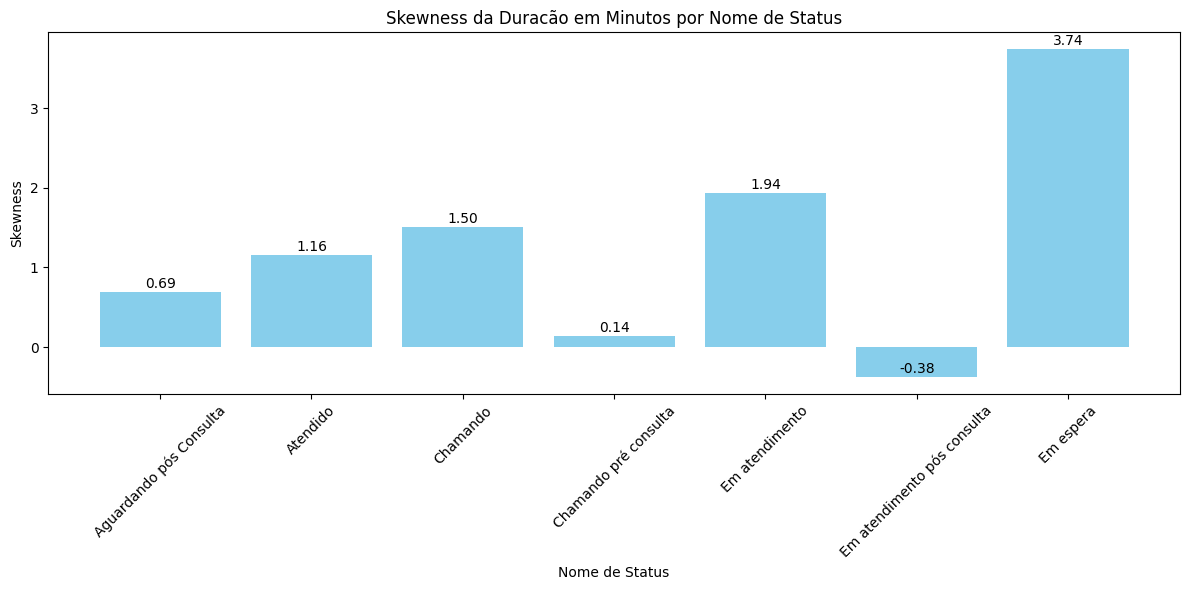

In [15]:

from scipy.stats import skew

skewness_por_status = df_tm1.groupby('nome_status')['duracao_d_minutos'].apply(skew).reset_index()

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(skewness_por_status['nome_status'], skewness_por_status['duracao_d_minutos'], color='skyblue')

# Adicionar rótulos aos dados
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

# Configurações do gráfico
plt.title('Skewness da Duracão em Minutos por Nome de Status')
plt.xlabel('Nome de Status')
plt.ylabel('Skewness')
plt.xticks(rotation=45)  # Rotacionar rótulos do eixo X para melhor legibilidade

# Exibir o gráfico
plt.tight_layout()
plt.show()

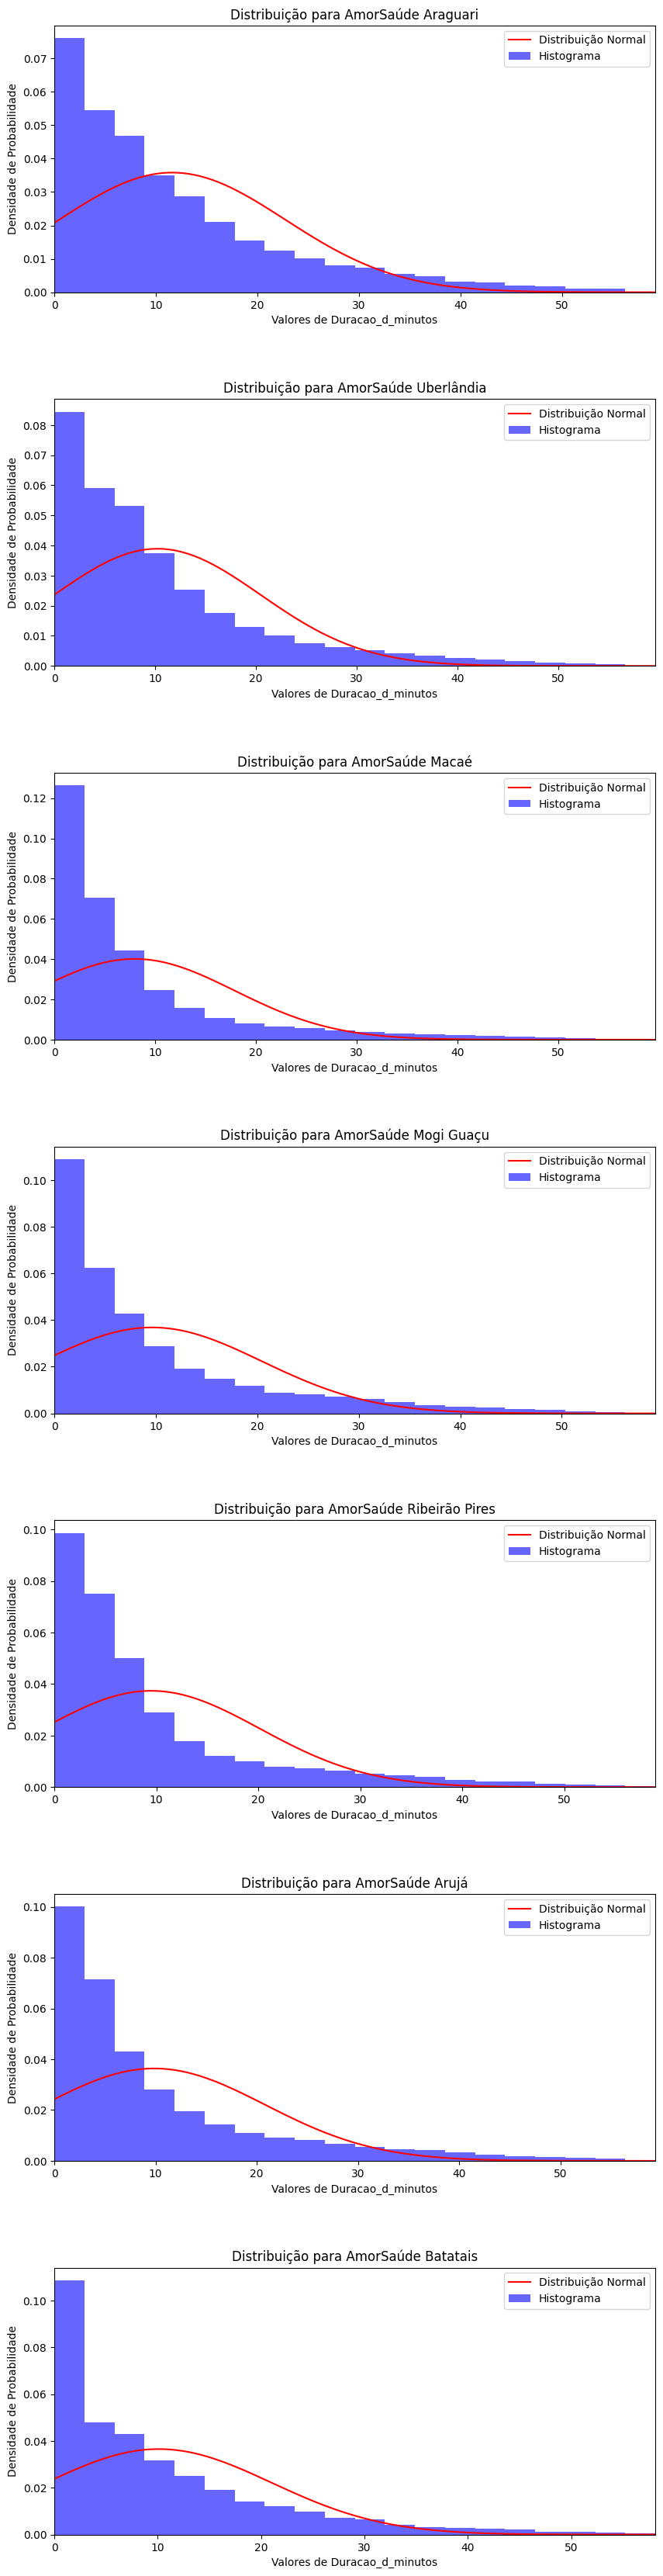

In [16]:
# Lista de todos os valores únicos em 'nome_fantasia'
nomes_de_fantasia = df_tm1['nome_fantasia'].unique()

# Configurar subplots para criar um gráfico para cada nome_fantasia
num_plots = len(nomes_de_fantasia)
fig, axes = plt.subplots(num_plots, figsize=(10, 6*num_plots))
plt.subplots_adjust(hspace=0.4)

# Loop através de cada nome_fantasia e criar a distribuição normal
for i, fantasia in enumerate(nomes_de_fantasia):
    dados = df_tm1[df_tm1['nome_fantasia'] == fantasia]['duracao_d_minutos']
    media = dados.mean()
    desvio_padrao = dados.std()
    
    x = np.linspace(dados.min(), dados.max(), 100)
    y = norm.pdf(x, media, desvio_padrao)
    
    # Plotar a distribuição normal
    axes[i].plot(x, y, label='Distribuição Normal', color='red')
    
    # Plotar um histograma dos dados
    axes[i].hist(dados, bins=20, density=True, alpha=0.6, color='blue', label='Histograma')
    
    # Configurar os limites do eixo x para limitar o intervalo
    limites_x = [dados.min(), dados.max()]
    axes[i].set_xlim(limites_x)
    
    # Configurar títulos e legendas
    axes[i].set_title(f'Distribuição para {fantasia}')
    axes[i].set_xlabel('Valores de Duracao_d_minutos')
    axes[i].set_ylabel('Densidade de Probabilidade')
    axes[i].legend()

# Exibir os gráficos
plt.show()


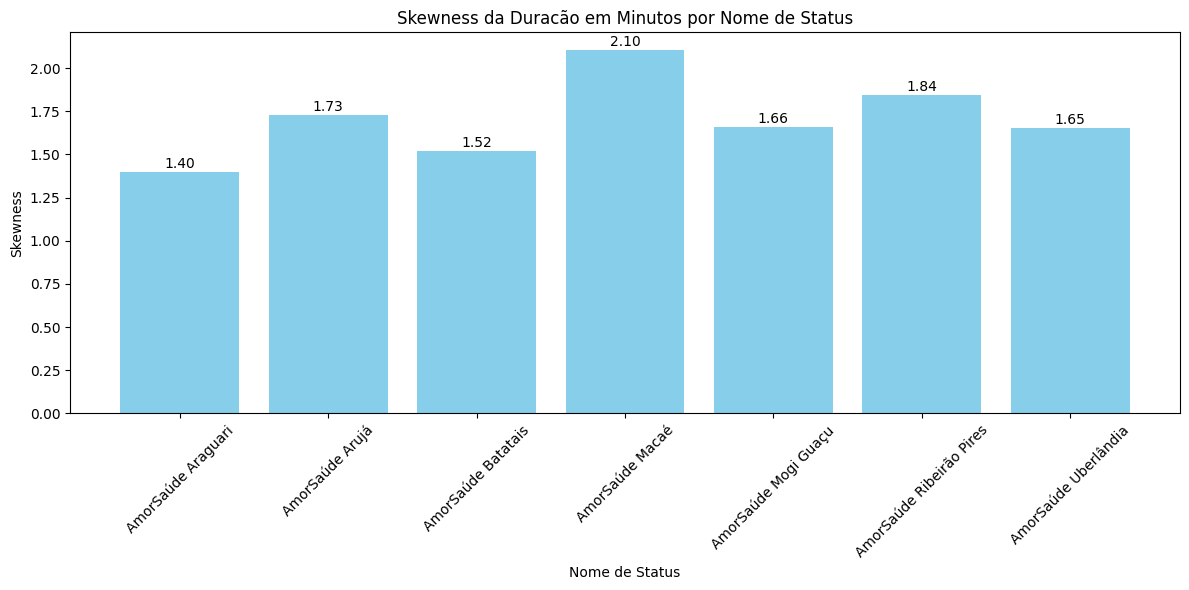

In [17]:
# Agrupar por nome_status e calcular a skewness para duracao_d_minutos
skewness_por_status = df_tm1.groupby('nome_fantasia')['duracao_d_minutos'].apply(skew).reset_index()

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(skewness_por_status['nome_fantasia'], skewness_por_status['duracao_d_minutos'], color='skyblue')

# Adicionar rótulos aos dados
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

# Configurações do gráfico
plt.title('Skewness da Duracão em Minutos por Nome de Status')
plt.xlabel('Nome de Status')
plt.ylabel('Skewness')
plt.xticks(rotation=45)  # Rotacionar rótulos do eixo X para melhor legibilidade

# Exibir o gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_40877/950166896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tm1['data'] = pd.to_datetime(df_tm1['data'])
/tmp/ipykernel_40877/950166896.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tm1['ano'] = df_tm1['data'].dt.year
/tmp/ipykernel_40877/950166896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

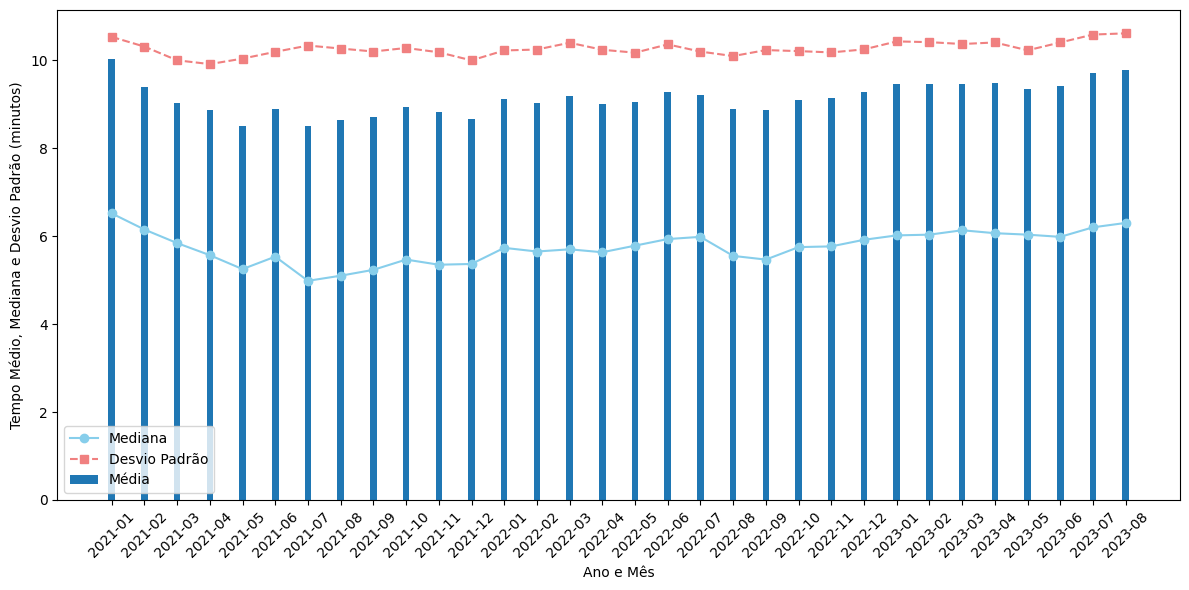

In [18]:
df_tm1['data'] = pd.to_datetime(df_tm1['data'])

# Extrair o ano e o mês da coluna 'data'
df_tm1['ano'] = df_tm1['data'].dt.year
df_tm1['mes'] = df_tm1['data'].dt.month

# Agrupar por ano e mês e calcular média, mediana e desvio padrão
agrupado = df_tm1.groupby(['ano', 'mes'])['duracao_d_minutos'].agg(['mean', 'median', 'std']).reset_index()

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))

# Barras da média
plt.bar(agrupado.index, agrupado['mean'], width=0.2, label='Média', align='center')

# Linha da mediana
plt.plot(agrupado.index, agrupado['median'], marker='o', linestyle='-', color='skyblue', label='Mediana')

# Linha do desvio padrão
plt.plot(agrupado.index, agrupado['std'], marker='s', linestyle='--', color='lightcoral', label='Desvio Padrão')

# Configurações do eixo X
plt.xticks(agrupado.index, [f"{ano}-{mes:02d}" for ano, mes in zip(agrupado['ano'], agrupado['mes'])], rotation=45)

# Rótulos e legenda
plt.xlabel('Ano e Mês')
plt.ylabel('Tempo Médio, Mediana e Desvio Padrão (minutos)')
plt.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()


/tmp/ipykernel_40877/1109160539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tm1['data'] = pd.to_datetime(df_tm1['data'])
/tmp/ipykernel_40877/1109160539.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tm1['ano'] = df_tm1['data'].dt.year
/tmp/ipykernel_40877/1109160539.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

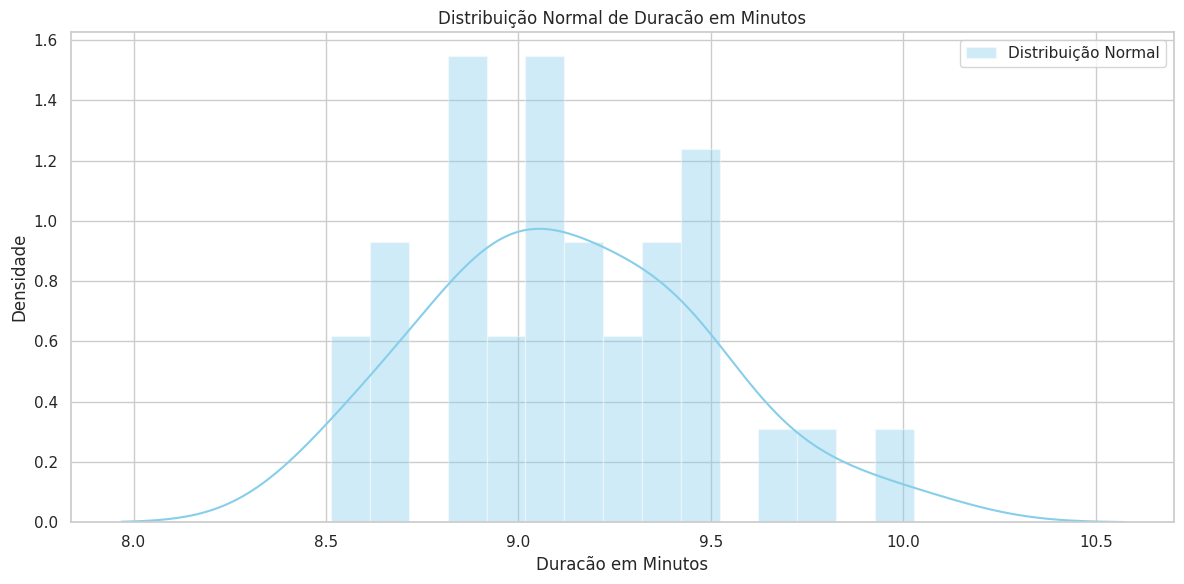

In [19]:
df_tm1['data'] = pd.to_datetime(df_tm1['data'])

# Extrair o ano e o mês da coluna 'data'
df_tm1['ano'] = df_tm1['data'].dt.year
df_tm1['mes'] = df_tm1['data'].dt.month

# Agrupar por ano e mês e calcular a média
agrupado = df_tm1.groupby(['ano', 'mes'])['duracao_d_minutos'].mean().reset_index()

# Configurar o estilo do seaborn
sns.set(style="whitegrid")

# Criar o gráfico de distribuição normal
plt.figure(figsize=(12, 6))
sns.distplot(agrupado['duracao_d_minutos'], hist=True, kde=True, color='skyblue', bins=15, label='Distribuição Normal')

# Configurações do gráfico
plt.title('Distribuição Normal de Duracão em Minutos')
plt.xlabel('Duracão em Minutos')
plt.ylabel('Densidade')
plt.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [20]:
import scipy.stats as stats

media_duracao = df_tm1['duracao_d_minutos'].mean()
desvio_padrao_duracao = df_tm1['duracao_d_minutos'].std()

# Defina o intervalo em torno da média (por exemplo, +/- 1 desvio padrão)
intervalo_inferior = media_duracao - desvio_padrao_duracao
intervalo_superior = media_duracao + desvio_padrao_duracao

# Calcule a probabilidade usando a função de densidade de probabilidade (PDF)
probabilidade = stats.norm.cdf(intervalo_superior, loc=media_duracao, scale=desvio_padrao_duracao) - stats.norm.cdf(intervalo_inferior, loc=media_duracao, scale=desvio_padrao_duracao)

# A probabilidade representa a chance de que duracao_d_minutos esteja dentro do intervalo
print(f"A probabilidade de duracao_d_minutos estar dentro de +/- um desvio padrão da média é: {probabilidade:.2f}")

A probabilidade de duracao_d_minutos estar dentro de +/- um desvio padrão da média é: 0.68
